# TIMESERIES ANOMALY DETECTION
## AUTHOR: ANTE DUJIC
<hr style="border:2px solid gray"> </hr>

<center><img src="https://i0.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1200%2C800&ssl=1" width="400"/></center>

Anomaly detection involves identifying the differences, deviations, and exceptions from the norm in a dataset. It’s sometimes referred to as outlier detection (i.e., looking at a dataset to identify any outlying or unusual datapoints, data groups, or activity).[1]

<hr style="border:2px solid gray"> </hr>

##### WHAT IS AUTOENCODER?
##### TIMESERIES?
##### ANOMALY DETECTION IN MACHINE LEARNING?
##### KERAS?

***

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

### DATA

Explain the data: https://www.kaggle.com/datasets/boltzmannbrain/nab

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

##### TIMESERIES DATA WITHOUT ANOMALIES

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [5]:
# 
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [6]:
# 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# 
df_small_noise.iloc[0]['value']

18.3249185392

In [8]:
# 
df_small_noise.shape

(4032, 1)

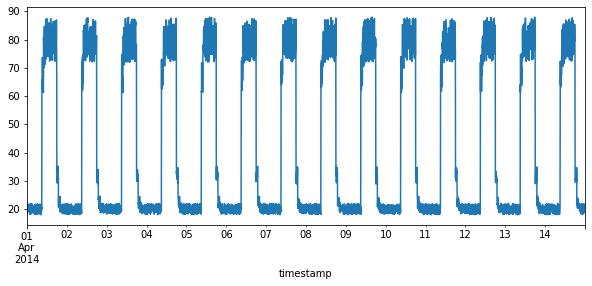

In [9]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

LOOK INTO BETTER LOOKING PLOTS

##### TIMESERIES DATA WITH ANOMALIES

In [10]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [11]:
#
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [12]:
# 
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [13]:
# 
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [14]:
# 
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [15]:
# 
df_daily_jumpsup.shape

(4032, 1)

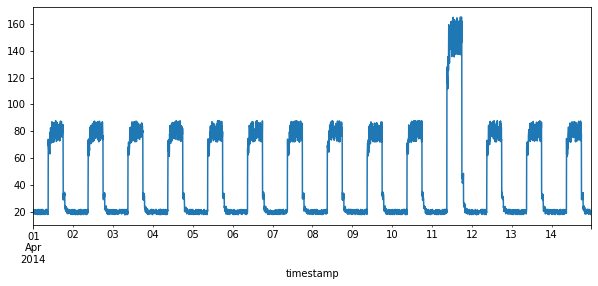

In [16]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

In [17]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


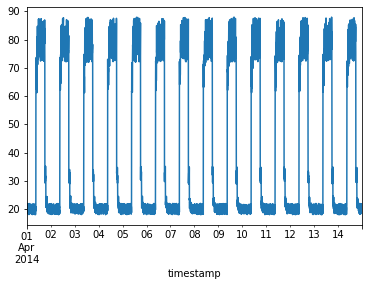

In [18]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

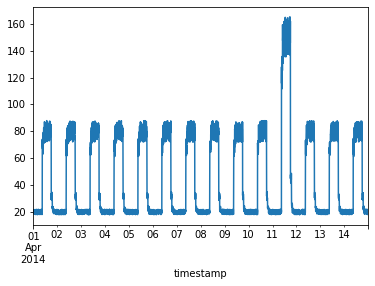

In [19]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### PREPARE TRAINING DATA

In [20]:
# 
train_mean = df_small_noise.mean()
train_mean

value    42.438353
dtype: float64

In [21]:
# 
train_std = df_small_noise.std()
train_std

value    28.077122
dtype: float64

In [22]:
# 
df_train_vals = (df_small_noise - train_mean) / train_std

In [23]:
# 
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [24]:
# 
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [25]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [26]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [27]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

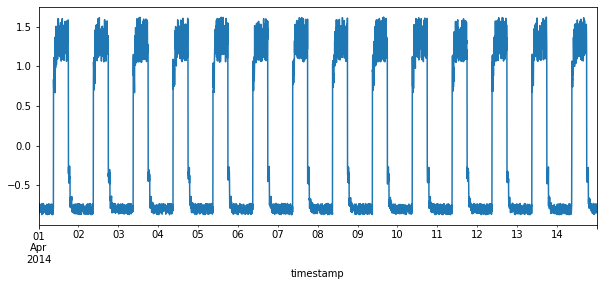

In [28]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [29]:
print("Number of training samples:", len(df_train_vals))

Number of training samples: 4032


In [30]:
# 
window_size = 288

explain window

In [31]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [32]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [33]:
# Remove brackets.
len(L) - win_size + 1

10

In [34]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [35]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [36]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [37]:
# Generated training sequences for use in the model.
def windows(values, time_steps=window_size):
    # Empty list
    output = []
    # Loop through all the possible windows
    for i in range(len(values) - time_steps + 1):
        # Append the window to the list
        output.append(values[i : (i + time_steps)])
    # Stac the result
    return np.stack(output)

In [38]:
# 
x_train = windows(df_train_vals)

In [39]:
# 
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [40]:
# 
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [41]:
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


### BUILD A MODEL

In [42]:
#
layers = [
    # https://keras.io/api/layers/core_layers/input/
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    # https://keras.io/api/layers/convolution_layers/convolution1d/
    keras.layers.Conv1D(
      filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    # https://keras.io/api/layers/regularization_layers/dropout/
    keras.layers.Dropout(rate=0.2),
    #
    keras.layers.Conv1D(
      filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Conv1DTranspose(
      filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Dropout(rate=0.2),
    #
    keras.layers.Conv1DTranspose(
      filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [43]:
#
model = keras.Sequential(layers)

In [44]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [45]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

### TRAIN THE MODEL

In [47]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 6s 119ms/step - loss: 0.5244 - val_loss: 0.1017
Epoch 2/50
27/27 [==============================] - 3s 93ms/step - loss: 0.0750 - val_loss: 0.0393
Epoch 3/50
27/27 [==============================] - 2s 92ms/step - loss: 0.0556 - val_loss: 0.0360
Epoch 4/50
27/27 [==============================] - 3s 94ms/step - loss: 0.0481 - val_loss: 0.0299
Epoch 5/50
27/27 [==============================] - 3s 94ms/step - loss: 0.0428 - val_loss: 0.0270
Epoch 6/50
27/27 [==============================] - 3s 99ms/step - loss: 0.0382 - val_loss: 0.0246
Epoch 7/50
27/27 [==============================] - 3s 115ms/step - loss: 0.0341 - val_loss: 0.0225
Epoch 8/50
27/27 [==============================] - 3s 99ms/step - loss: 0.0311 - val_loss: 0.0210
Epoch 9/50
27/27 [==============================] - 3s 107ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 10/50
27/27 [==============================] - 3s 97ms/step - loss: 0.0267 - val_loss: 0.0201
Epoch 

In [48]:
history.history["loss"]

[0.5244070887565613,
 0.07496792078018188,
 0.055589284747838974,
 0.048101238906383514,
 0.042757704854011536,
 0.0382411815226078,
 0.03412206098437309,
 0.03106902539730072,
 0.028722474351525307,
 0.02672415040433407,
 0.025134380906820297,
 0.02382696606218815,
 0.022659221664071083,
 0.02166789025068283,
 0.02081545814871788]

In [49]:
history.history["val_loss"]

[0.101700060069561,
 0.039341580122709274,
 0.03595070540904999,
 0.029918789863586426,
 0.02699253521859646,
 0.0245863925665617,
 0.022499335929751396,
 0.021014312282204628,
 0.02067815326154232,
 0.020100072026252747,
 0.02137942425906658,
 0.022174270823597908,
 0.022842559963464737,
 0.022069469094276428,
 0.023821614682674408]

explain history object

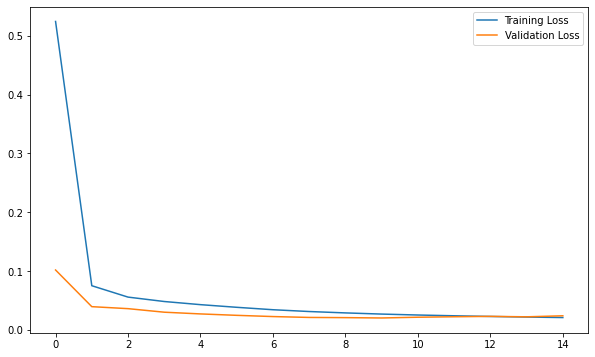

In [50]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

### ANOMALY DETECTION

In [54]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 2s 15ms/step


In [55]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

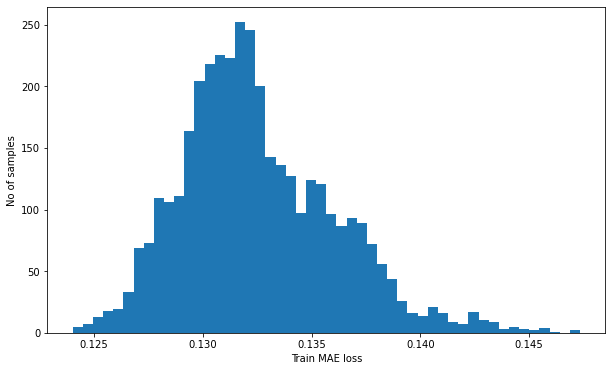

In [56]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [58]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
# 
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.14733075481931582


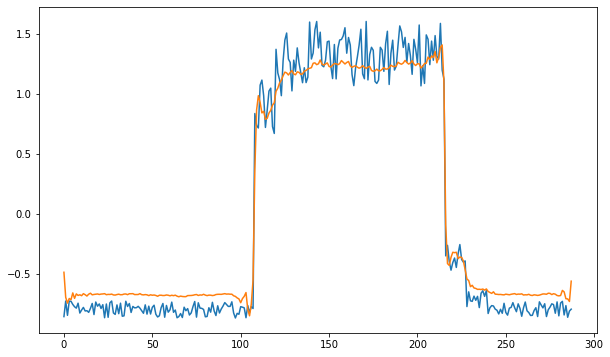

In [59]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [61]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

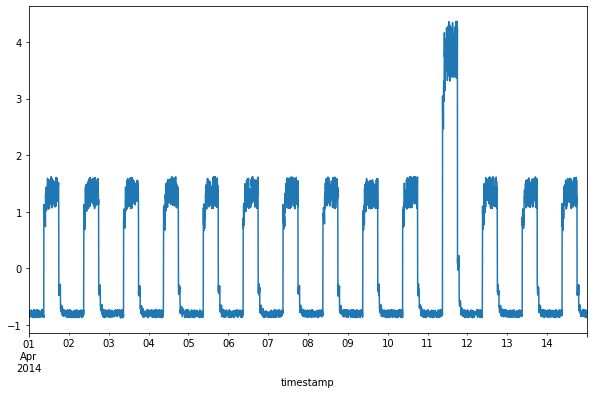

In [62]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [67]:
# Create sequences from test values.
x_test = windows(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [65]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 2s 16ms/step


In [66]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.12803427],
       [0.13391561],
       [0.1302257 ],
       ...,
       [0.12982254],
       [0.13166715],
       [0.12932077]])

In [70]:
# 
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss

array([0.12803427, 0.13391561, 0.1302257 , ..., 0.12982254, 0.13166715,
       0.12932077])

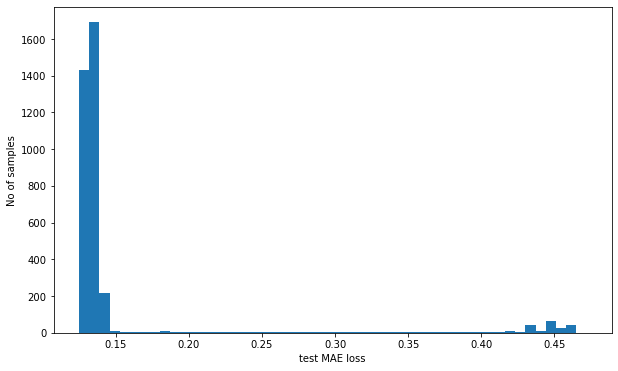

In [71]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [77]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

In [75]:
print("Number of anomaly samples: ", np.sum(anomalies))

Number of anomaly samples:  399


In [78]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [79]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

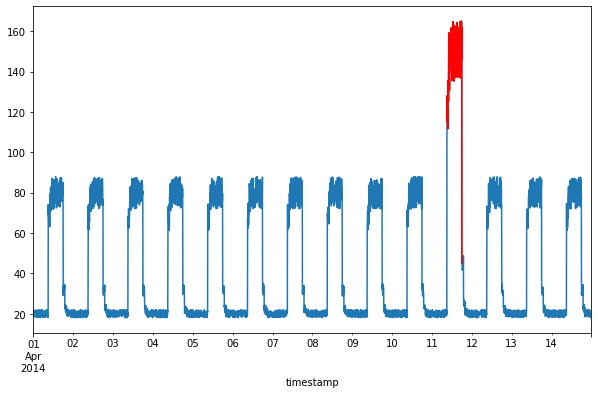

In [80]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

### REFERENCES

1. https://thedatascientist.com/anomaly-detection-why-you-need-it/
2. 